# Visualizations of an unconditional diffusion model trained on MRMS

* Old notebook: the data, model, and examples were deleted to free space.

In [ ]:
import os
import sys
import time
import math
import logging
import warnings
import numpy as np
from glob import glob

warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

logging.getLogger("tensorflow").setLevel(logging.ERROR) 

In [2]:
from scipy.ndimage import gaussian_filter

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from GroupNormalization import GroupNormalization

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu
import graph_utils as gu

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameters

In [6]:
total_timesteps = 1000
norm_groups = 8  # Number of groups used in GroupNormalization layer
lr = 1e-4

img_size = 128
img_channels = 5
clip_min = -1.0
clip_max = 1.0

max_apcp = 4.0
time_step_valid = 200

first_conv_channels = 64
widths = [64, 128, 256, 512]
has_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

L_valid = 50

load_num = 3
save_num = 4

if load_num >= 0:
    model_name_load = '/glade/work/ksha/GAN/models/DB_ERA128_tune{}/'.format(load_num)
else:
    model_name_load = '/glade/work/ksha/GAN/models/DB_ERA128/'

model_name_save = '/glade/work/ksha/GAN/models/DB_ERA128_tune{}/'.format(save_num)

BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/'

## Diffusion model uiltilities (it has been moved to libs)

In [7]:
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            x_shape: Shape of the current batched samples
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extracts the mean, and the variance at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
            noise: Gaussian noise to be added at the current timestep
        Returns:
            Diffused samples at timestep `t`
        """
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

In [8]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )


class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        #inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj


class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb


def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, :
        ]

        x = GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        x = layers.Conv2D(
            width,
            kernel_size=3,
            strides=2,
            padding="same",
            kernel_initializer=kernel_init(1.0),
        )(x)
        return x

    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x

    return apply


def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply


## Model design

In [ ]:
def build_model(
    img_size,
    img_channels,
    widths,
    has_attention,
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    image_input = layers.Input(
        shape=(img_size, img_size, img_channels), name="image_input"
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = layers.Conv2D(
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)

        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(1, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input], x, name="unet")

In [9]:
# Build the unet model
model = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)

In [10]:
# Compile the model
model.compile(
    loss=keras.losses.MeanAbsoluteError(),
    optimizer=keras.optimizers.Adam(learning_rate=lr),
)

In [1]:
W_old = mu.dummy_loader(model_name_load)
model.set_weights(W_old)

In [12]:
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

## Validation set preparation

In [13]:
def precip_norm(x, max_apcp):
    x = 2*(x/max_apcp-0.5)
    x[x>1.0] = 1.0
    return x

max_apcp = 4.0

In [14]:
L_valid = 100
filenames = np.array(sorted(glob(BATCH_dir+'ERA5*.npy')))
L = len(filenames)
filename_valid = filenames[::20][:L_valid]

In [20]:
cmap_pct, A = gu.precip_cmap()

In [ ]:
def reverse_diffuse(x, time_step_valid, model, gdf_util, save_steps):
    #x = Y_valid_LR
    x_out_history = []
    L_valid, Lx, Ly, _ = x.shape
    noise_shape = (L_valid, Lx, Ly, 1)
    
    x_out = x[..., 0][..., None]
    x_c = x[..., 1:]
    
    for t in reversed(range(0, time_step_valid)):
        tt = tf.cast(tf.fill(L_valid, t), dtype=tf.int64)
        
        pred_noise = model.predict([np.concatenate((x_out, x_c), axis=-1), tt])
        
        model_mean, _, model_log_variance =  gdf_util.p_mean_variance(pred_noise, x=x_out, t=tt, clip_denoised=True)
        nonzero_mask = (1 - (np.array(tt)==0)).reshape((L_valid, 1, 1, 1))
        x_out = np.array(model_mean) + nonzero_mask * np.exp(0.5 * np.array(model_log_variance)) * np.random.normal(size=x_out.shape)
        if t in save_steps:
            x_out_history.append(np.copy(x_out))
            
    return x_out, x_out_history

## Examples of forward and reverse diffusion

**Select sample**

In [43]:
i = 65
name = filename_valid[i]
temp_data = np.load(name)
# plt.figure()
# plt.pcolormesh(temp_data[0, ..., 0], cmap=cmap_pct)

**timesteps to plot**

In [44]:
t_valid_ = np.array([10, 50, 100, 150, 200, 250, 300, 400, 500, 999])
t_valid = t_valid_.astype(int)

In [45]:
data_ = np.repeat(precip_norm(temp_data[0, ..., 0], max_apcp)[None, ..., None], 10, axis=0)
noise_valid = np.random.normal(size=(10, 128, 128, 1))
exampale = np.array(gdf_util.q_sample(data_, t_valid, noise_valid))

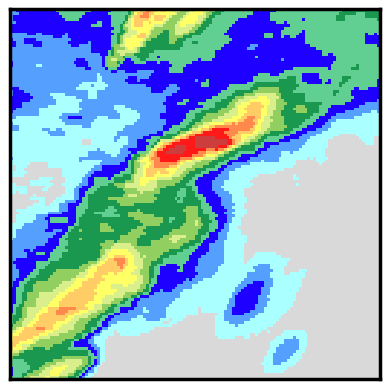

In [47]:
fig = plt.figure()
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_aspect('equal', adjustable='box')
ax.pcolormesh(precip_norm(temp_data[0, ..., 0], max_apcp), vmin=-1, vmax=1, cmap=cmap_pct)

# for i in range(10):
#     fig = plt.figure()
#     ax = fig.gca()
#     ax = gu.ax_decorate_box(ax)
#     ax.set_aspect('equal', adjustable='box')
#     ax.pcolormesh(exampale[i, ..., 0], vmin=-1, vmax=1, cmap=cmap_pct)

**Reverse diffusion**

In [58]:
data_LR = temp_data[..., 0][..., None]
data_LR_diffuse = gdf_util.q_sample(data_LR, total_timesteps, np.random.normal(size=(1, 128, 128, 1)))
pred_in = np.concatenate((np.array(data_LR_diffuse), temp_data[..., 1:]), axis=-1)
pred_HR, pred_HR_history = reverse_diffuse(pred_in, 1000, model, gdf_util, t_valid_)

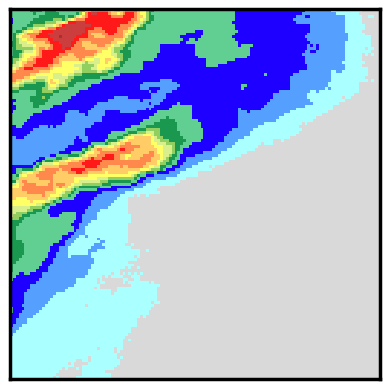

In [63]:
fig = plt.figure()
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_aspect('equal', adjustable='box')
ax.pcolormesh(pred_HR[0, ..., 0], vmin=-1, vmax=1, cmap=cmap_pct)

# for i in range(10):
#     fig = plt.figure()
#     ax = fig.gca()
#     ax = gu.ax_decorate_box(ax)
#     ax.set_aspect('equal', adjustable='box')
#     ax.pcolormesh(pred_HR_history[i][0, ..., 0], vmin=-1, vmax=1, cmap=cmap_pct)

## Applications of reverse diffusion (downscaling, inpainting, generative ensemble)

In [119]:
def LR_convert(data):
    x_lr = np.linspace(0, 1, 6)
    x_hr = np.linspace(0, 1, 128)
    hr_to_lr = interp2d(x_hr, x_hr, data, kind='linear')
    data_lr = hr_to_lr(x_lr, x_lr)
    lr_to_hr = interp2d(x_lr, x_lr, data_lr, kind='linear')
    data_hr = lr_to_hr(x_hr, x_hr)

    data_hr = gaussian_filter(data_hr, sigma=5)
    return data_hr

In [74]:
from scipy.interpolate import interp2d

In [104]:
i = 65
name = filename_valid[i]
temp_data = np.load(name)

In [132]:
HR_ = temp_data[0, ..., 0]
LR_ = LR_convert(HR_)

t_valid_ =  np.array([10, 50, 100, 150, 200, 250, 300, 400, 500, 800]) #np.array([10, 50, 100, 150, 200, 250, 300, 400, 500, 999])
t_valid = t_valid_.astype(int)

data_ = np.repeat(precip_norm(LR_, max_apcp)[None, ..., None], len(t_valid), axis=0)
noise_valid = np.random.normal(size=(len(t_valid), 128, 128, 1))
LR_bridge = np.array(gdf_util.q_sample(data_, t_valid, noise_valid))

In [138]:
# fig = plt.figure()
# ax = fig.gca()
# ax = gu.ax_decorate_box(ax)
# ax.set_aspect('equal', adjustable='box')
# ax.pcolormesh(precip_norm(LR_, max_apcp), vmin=-1, vmax=1, cmap=cmap_pct)

# for i in range(len(t_valid)):
#     fig = plt.figure()
#     ax = fig.gca()
#     ax = gu.ax_decorate_box(ax)
#     ax.set_aspect('equal', adjustable='box')
#     ax.pcolormesh(LR_bridge[i, ..., 0], vmin=-1, vmax=1, cmap=cmap_pct)

In [134]:
pred_in = np.concatenate((LR_bridge[-1, ..., 0][None, ..., None], temp_data[..., 1:]), axis=-1)
pred_HR, pred_HR_history = reverse_diffuse(pred_in, 1000, model, gdf_util, t_valid)

In [135]:
np.max(pred_HR[0, ..., 0])

0.7696883082389832

In [136]:
np.max(precip_norm(HR_, max_apcp))

0.702262585877415

In [139]:
# fig = plt.figure()
# ax = fig.gca()
# ax = gu.ax_decorate_box(ax)
# ax.set_aspect('equal', adjustable='box')
# ax.pcolormesh(pred_HR[0, ..., 0], vmin=-1, vmax=1, cmap=cmap_pct)

# for i in range(len(t_valid)):
#     fig = plt.figure()
#     ax = fig.gca()
#     ax = gu.ax_decorate_box(ax)
#     ax.set_aspect('equal', adjustable='box')
#     ax.pcolormesh(pred_HR_history[i][0, ..., 0], vmin=-1, vmax=1, cmap=cmap_pct)

**Ensemble estimations**

In [142]:
HR_ = temp_data[0, ..., 0]
LR_ = LR_convert(HR_)
data_ = precip_norm(LR_, max_apcp)[None, ..., None]

HR_collection = []

for i in range(10):

    noise_valid = np.random.normal(size=(1, 128, 128, 1))
    LR_diffuse = np.array(gdf_util.q_sample(data_, 800, noise_valid))
    
    pred_in = np.concatenate((LR_diffuse, temp_data[..., 1:]), axis=-1)
    pred_HR, _ = reverse_diffuse(pred_in, 1000, model, gdf_util, t_valid)
    HR_collection.append(pred_HR)

In [144]:
# for i in range(len(HR_collection)):
#     fig = plt.figure()
#     ax = fig.gca()
#     ax = gu.ax_decorate_box(ax)
#     ax.set_aspect('equal', adjustable='box')
#     ax.pcolormesh(HR_collection[i][0, ..., 0], vmin=-1, vmax=1, cmap=cmap_pct)

**inpainting**

In [ ]:
filenames = np.array(sorted(glob(BATCH_dir+'ERA5*.npy')))

In [228]:
L_valid = 100
i_start = 4100 #3700 #3500 #1500 #3000 #3100

filename_valid = filenames[::20][i_start:i_start+L_valid]

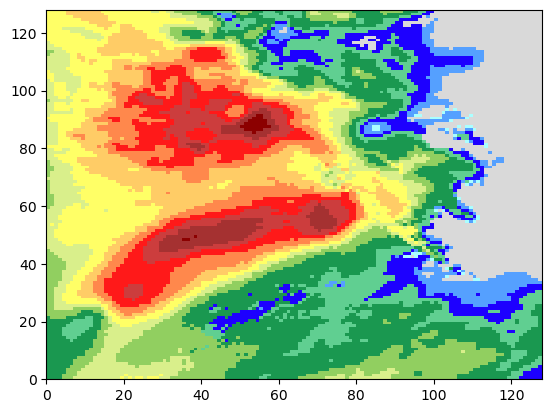

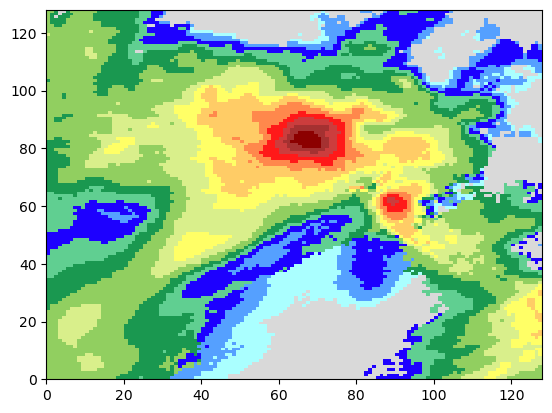

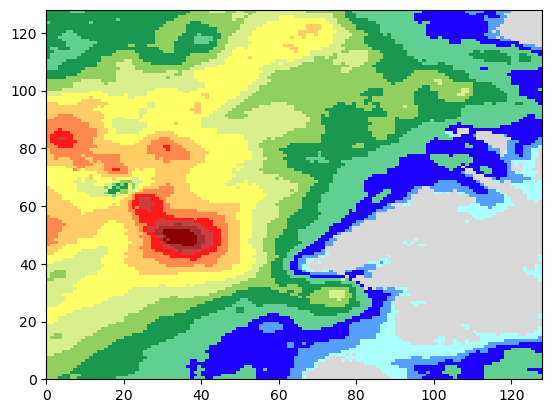

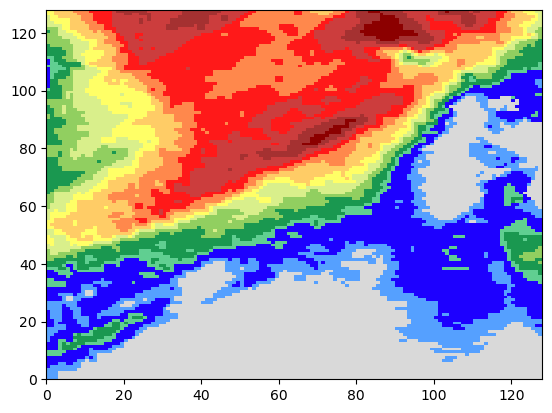

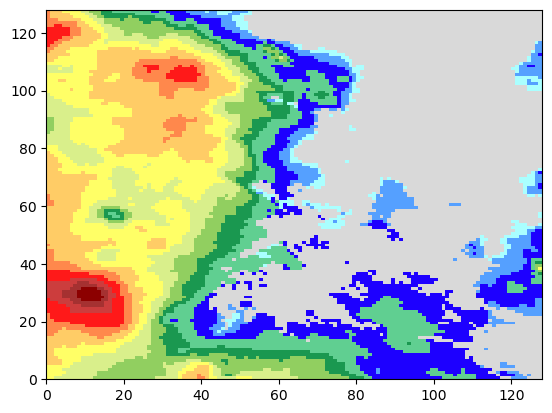

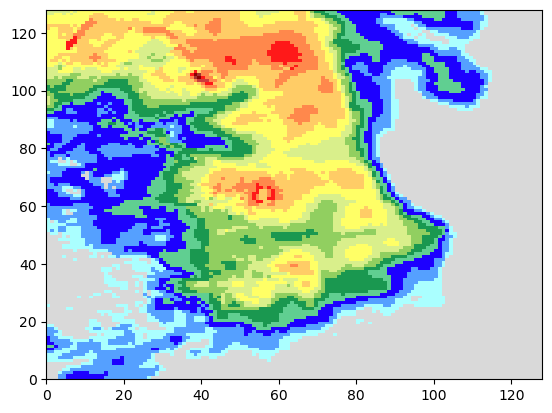

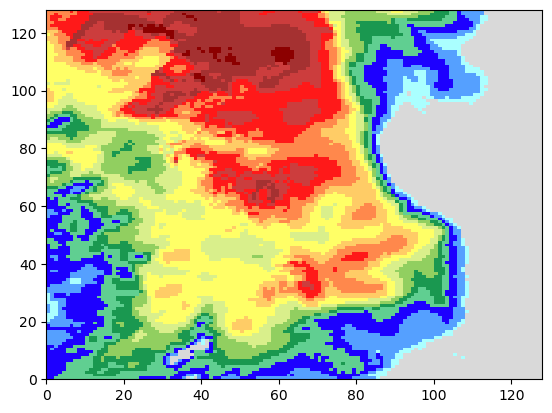

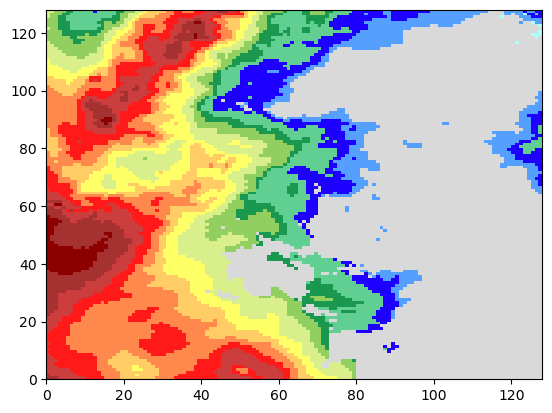

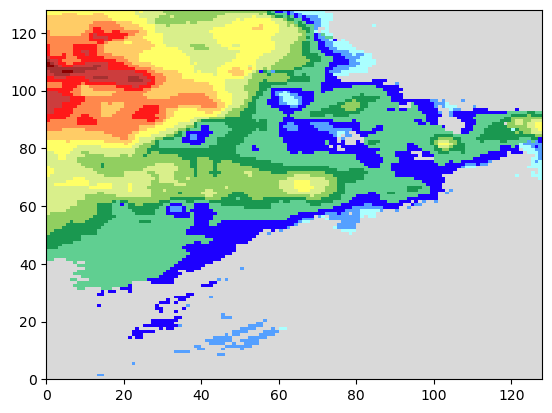

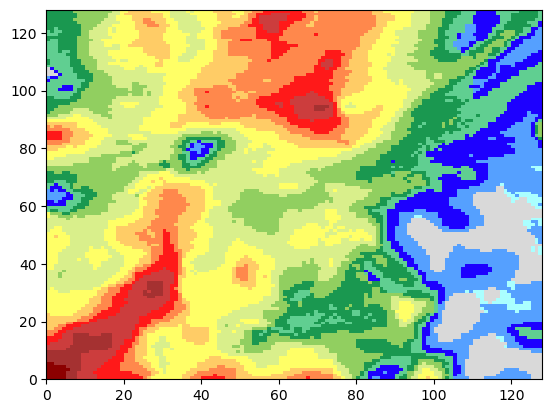

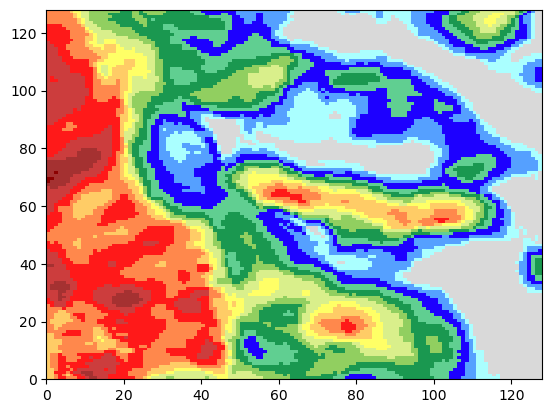

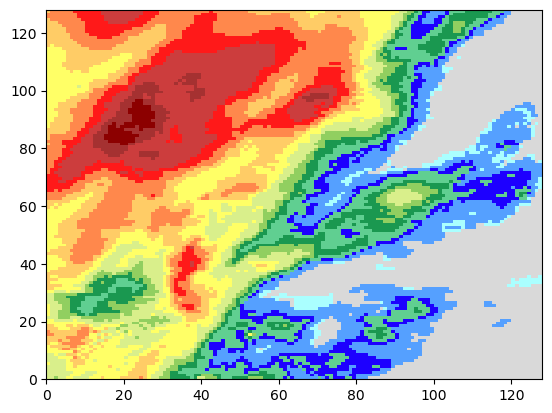

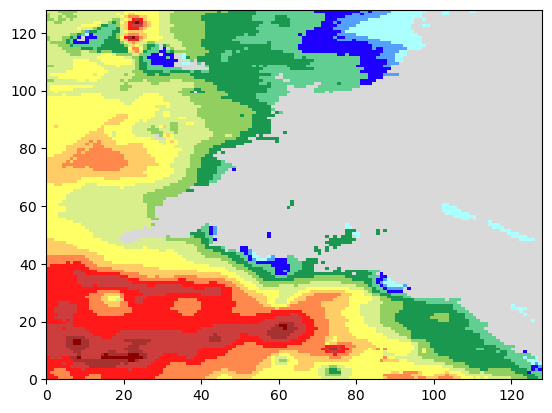

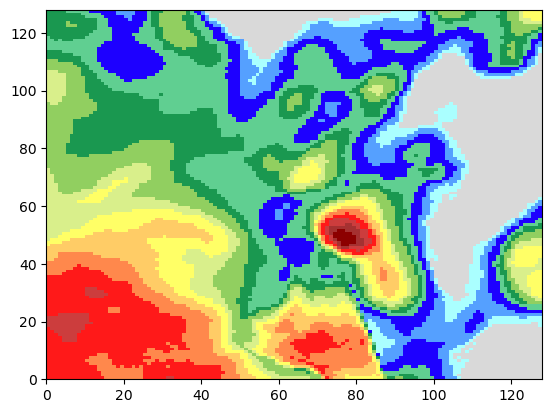

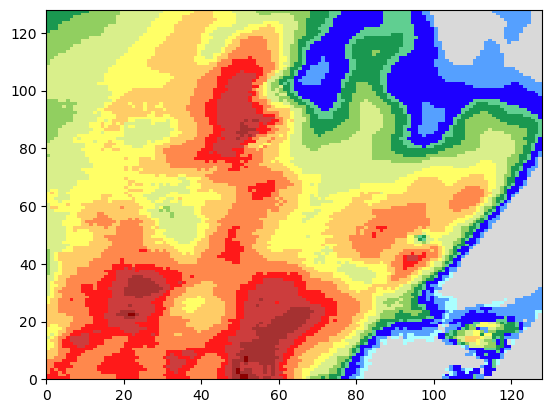

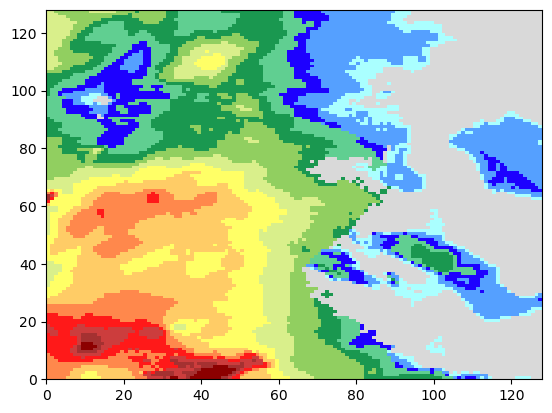

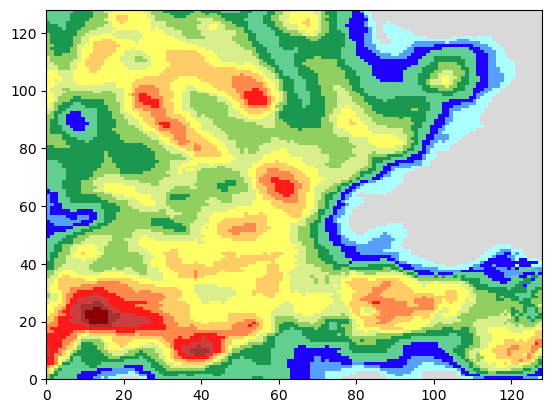

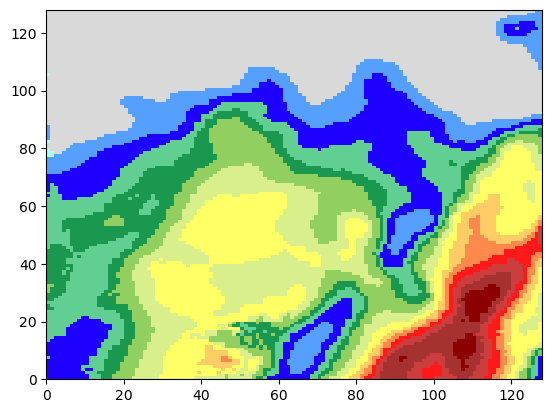

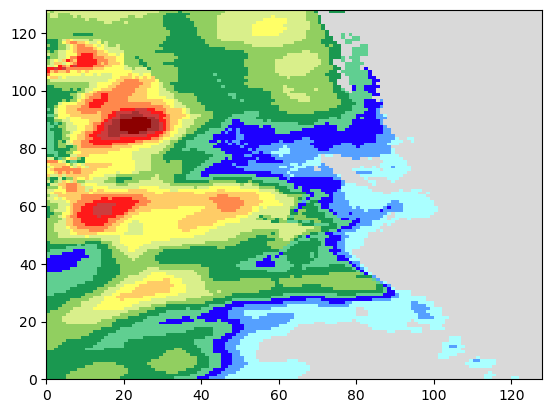

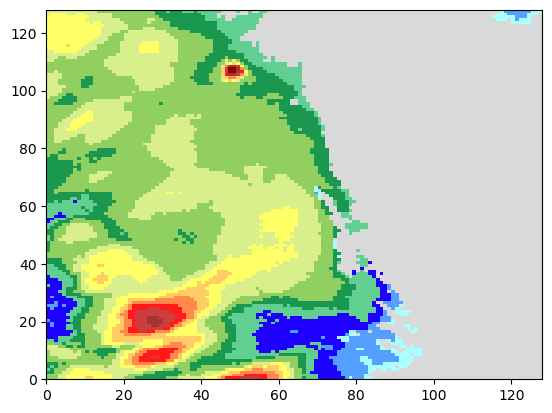

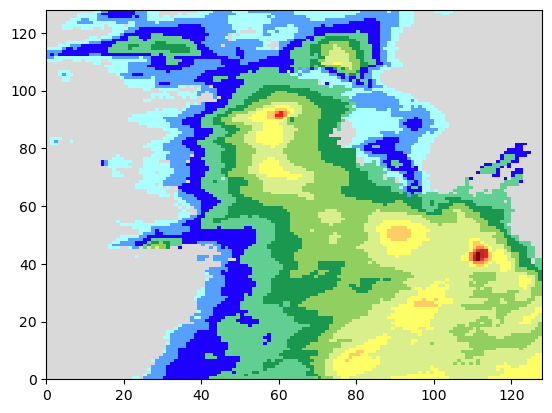

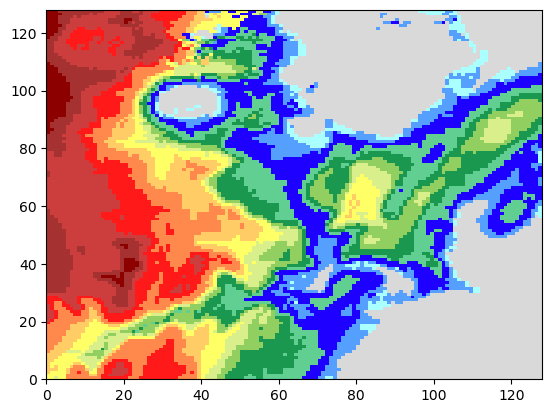

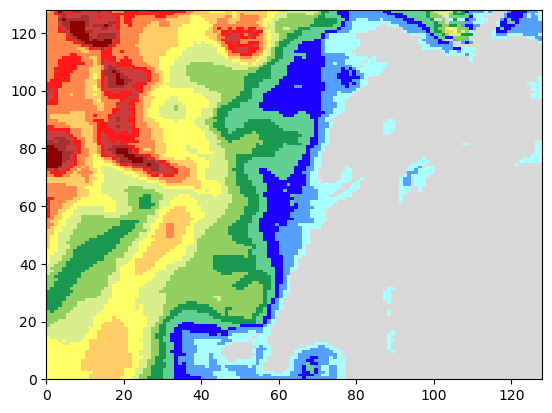

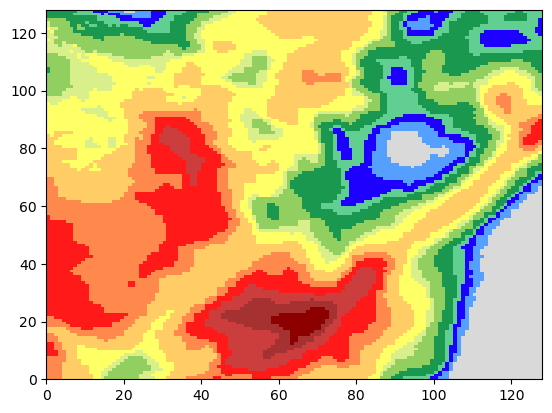

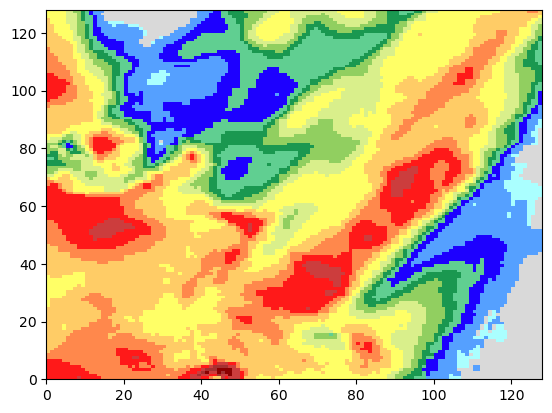

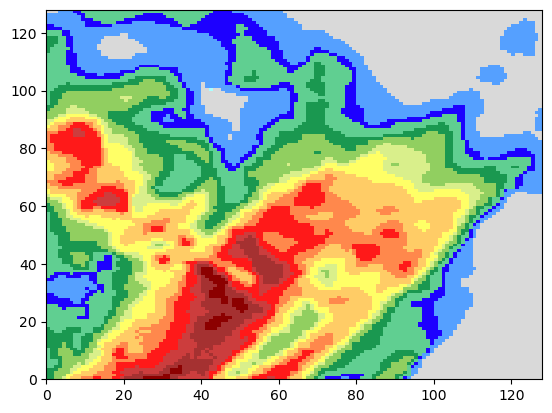

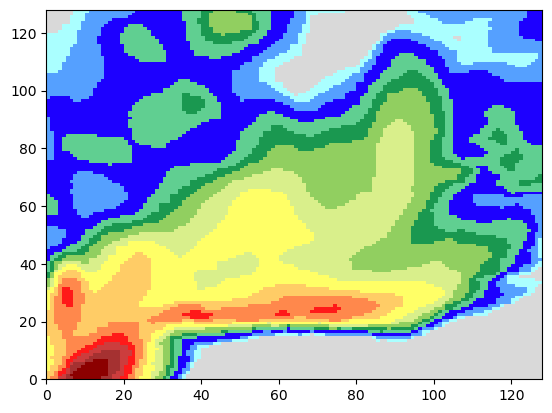

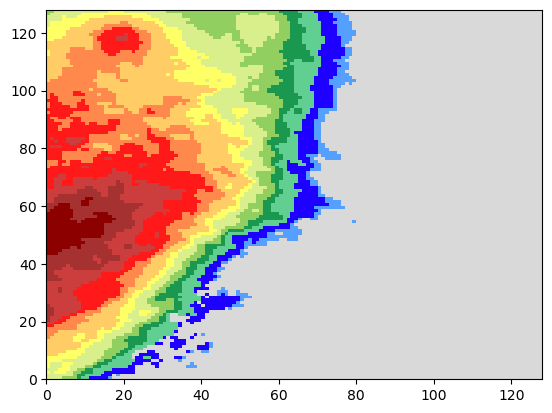

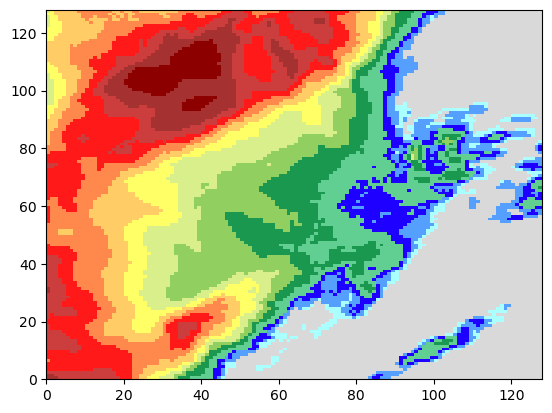

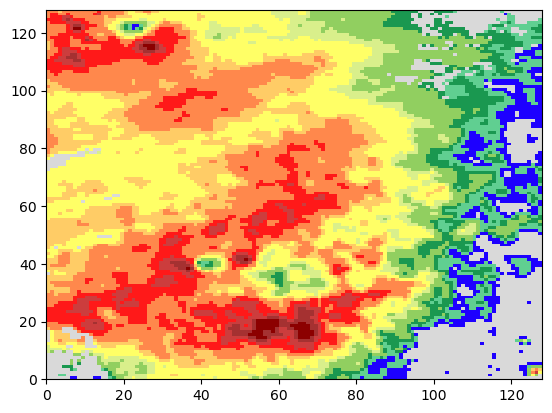

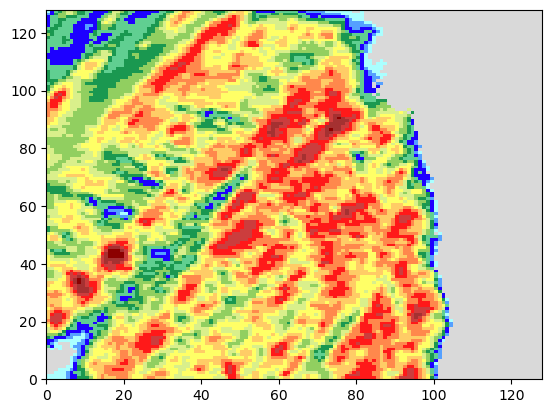

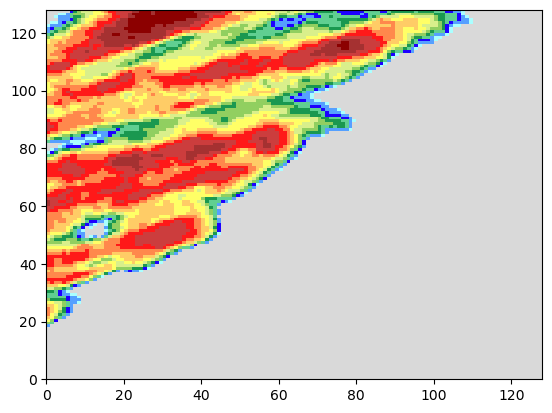

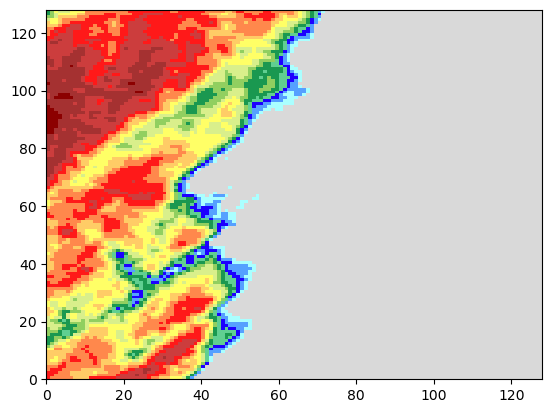

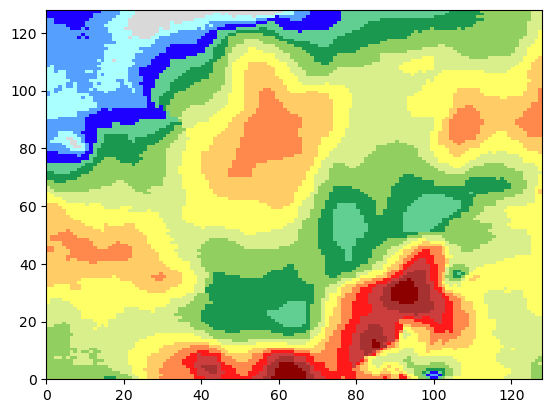

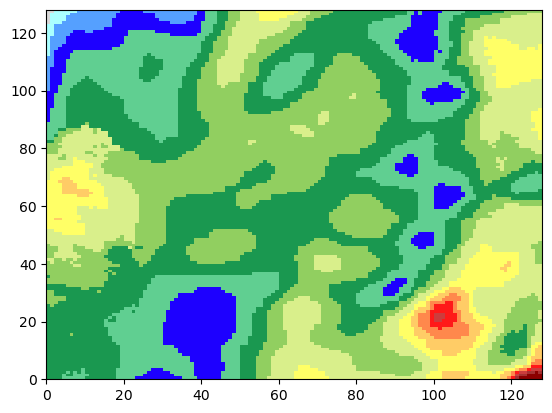

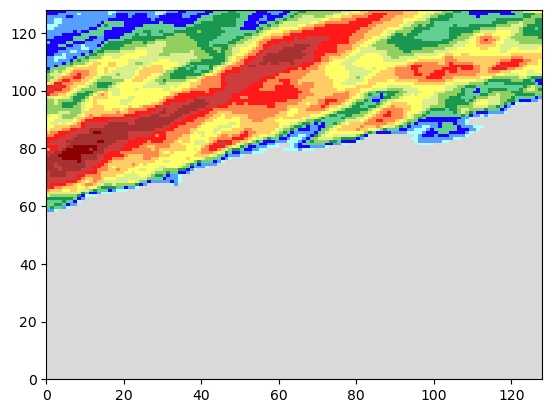

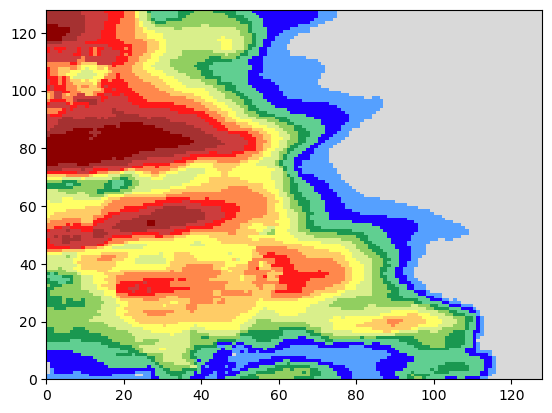

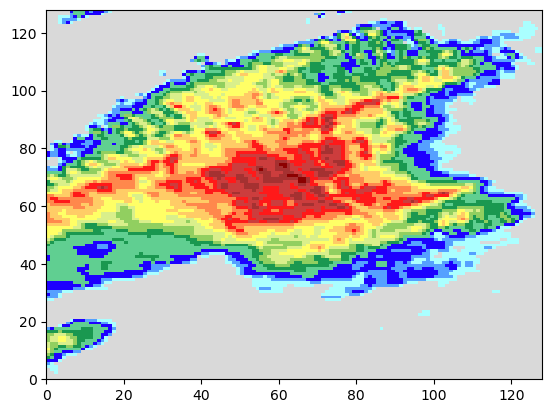

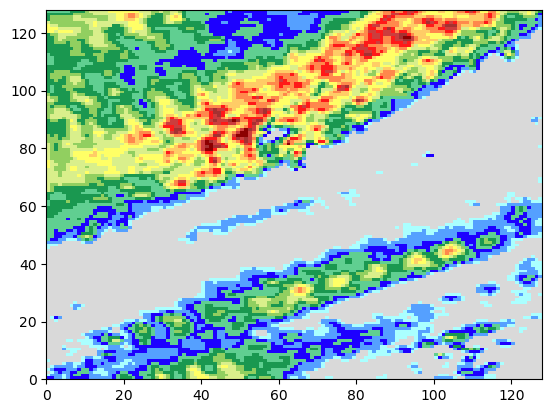

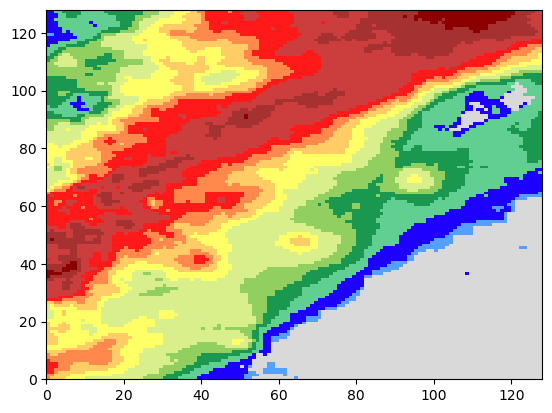

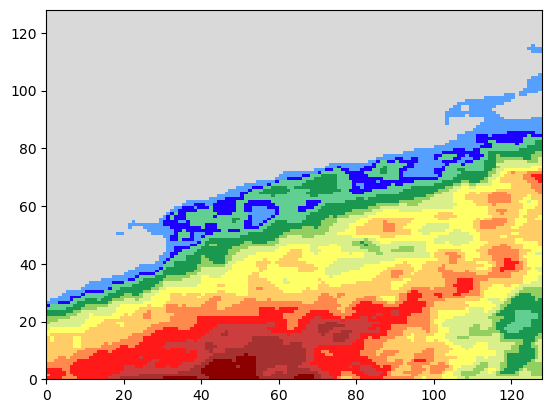

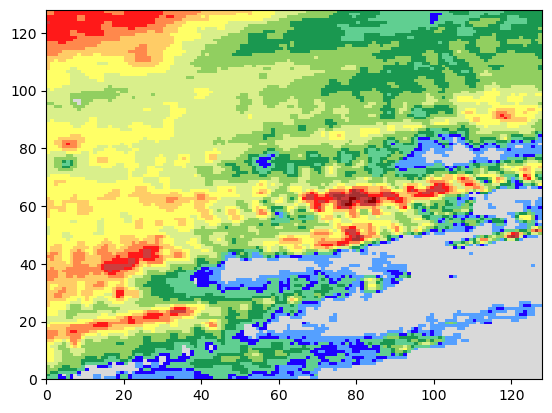

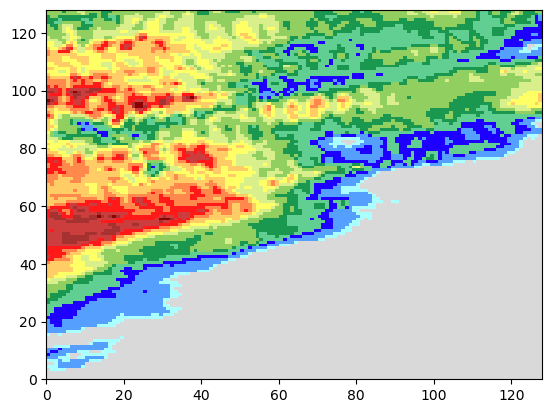

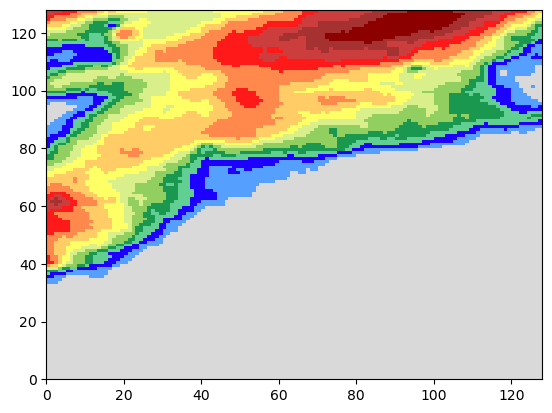

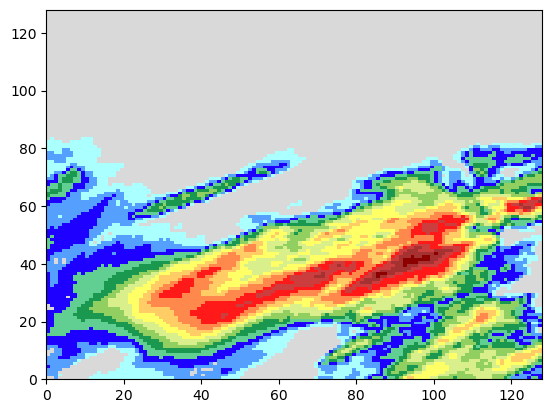

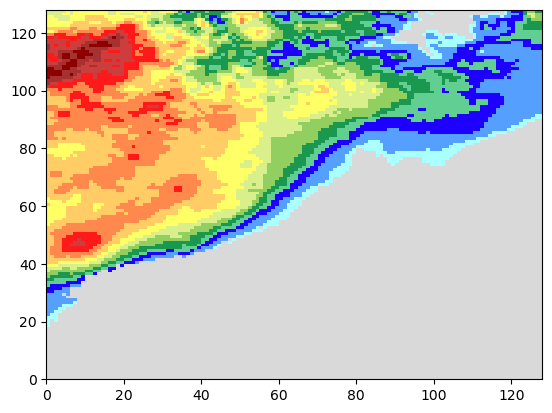

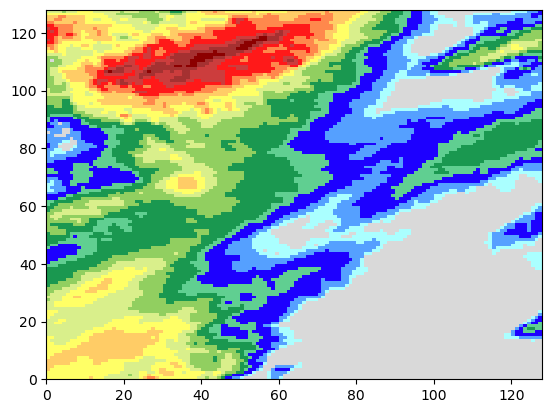

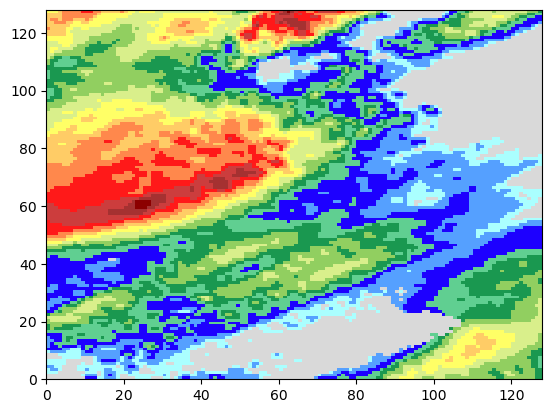

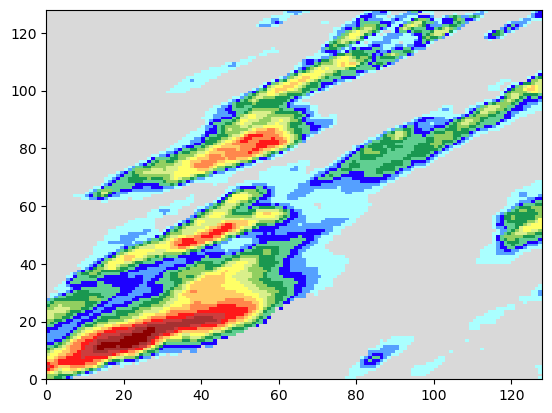

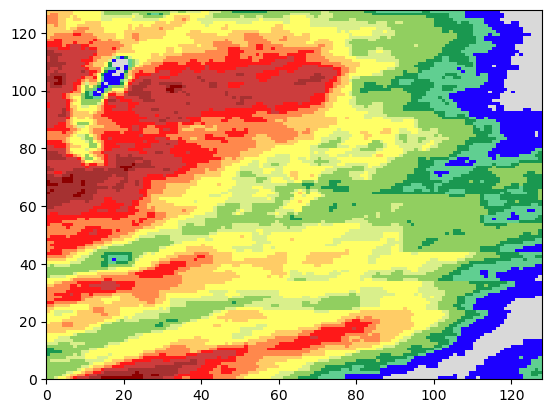

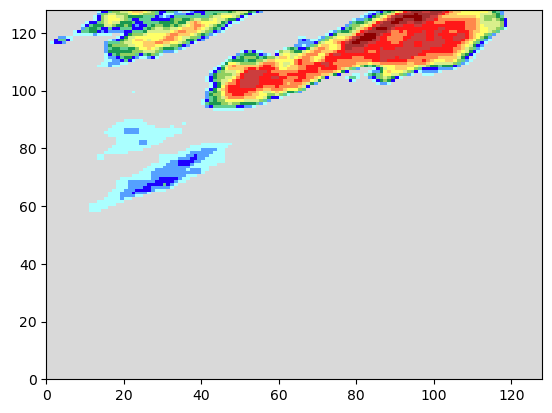

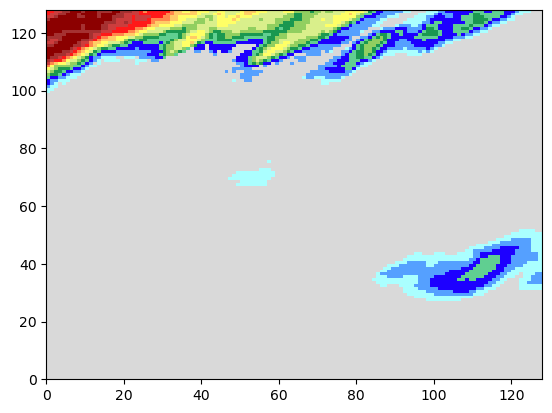

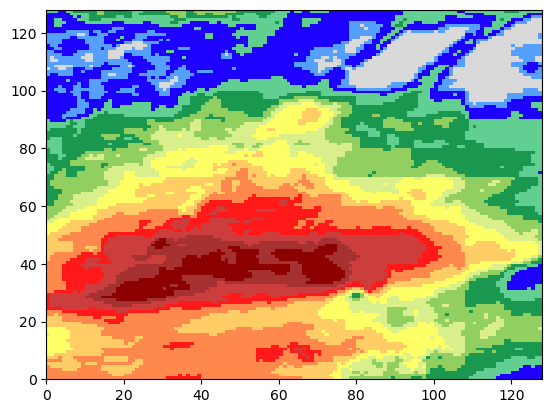

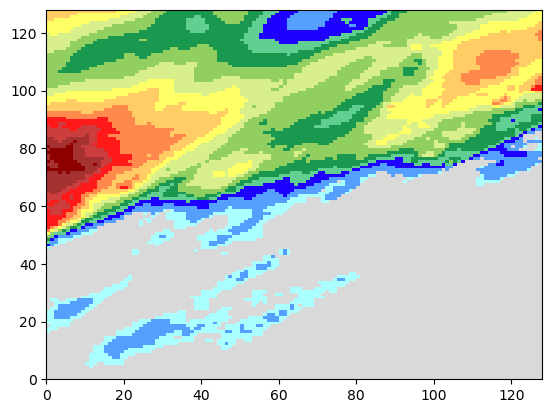

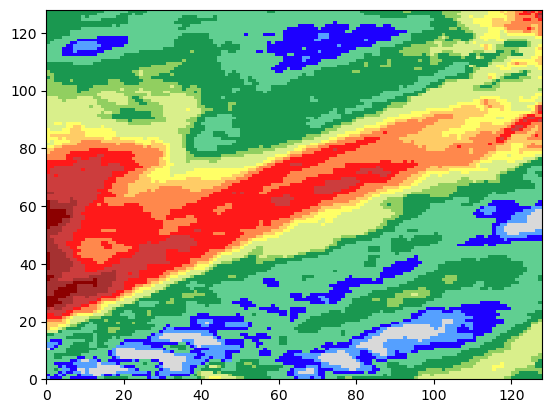

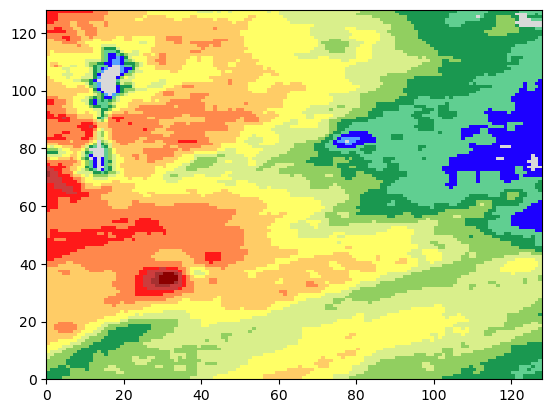

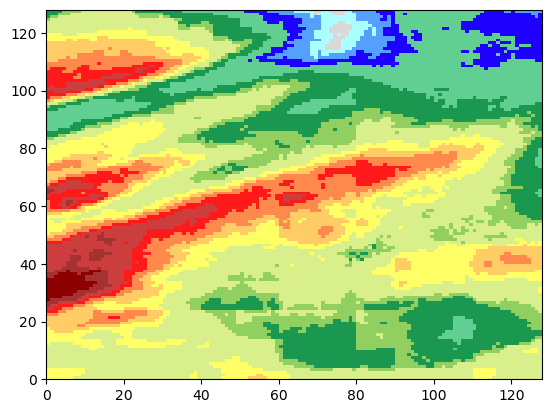

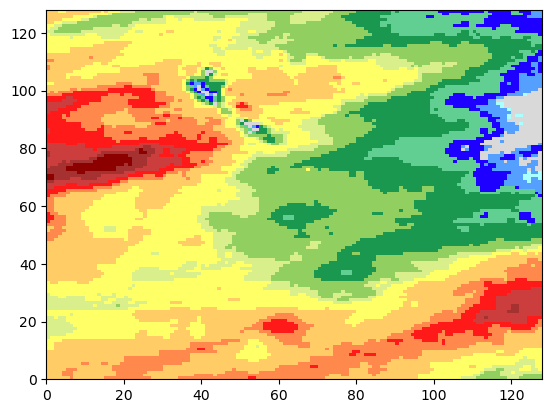

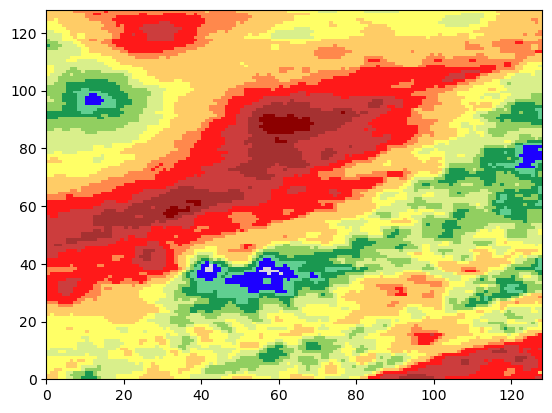

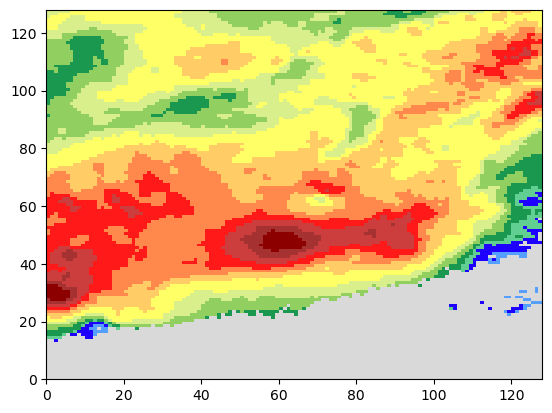

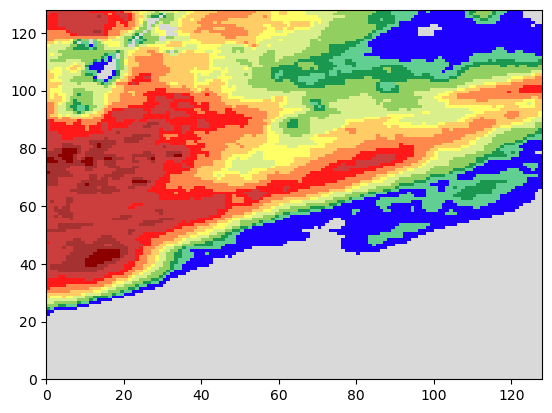

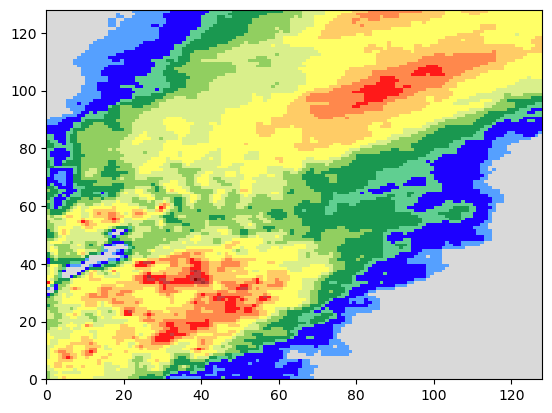

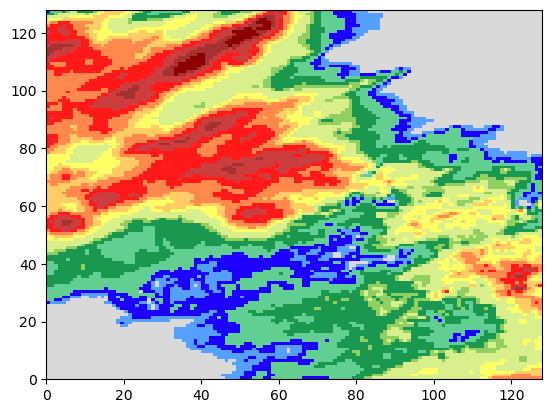

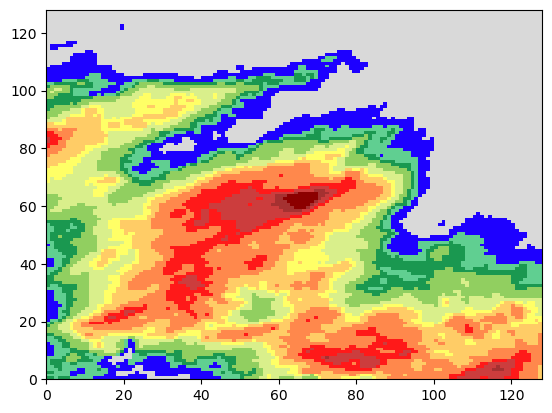

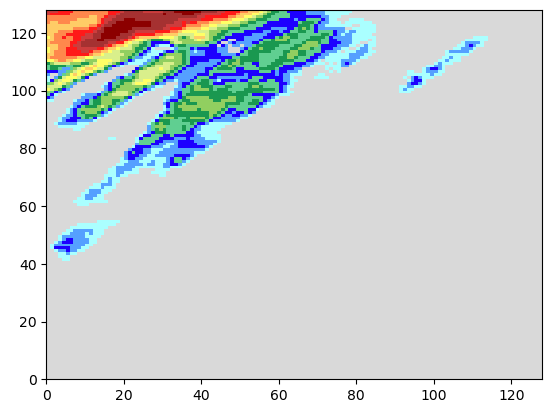

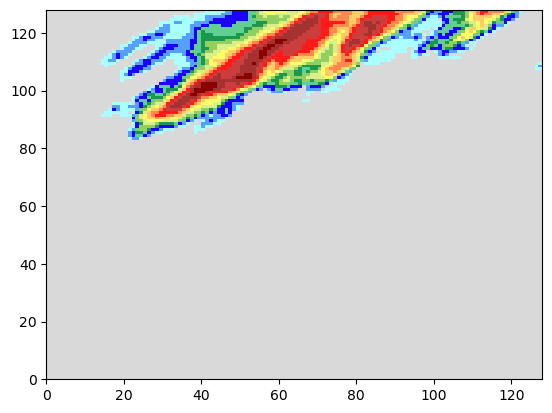

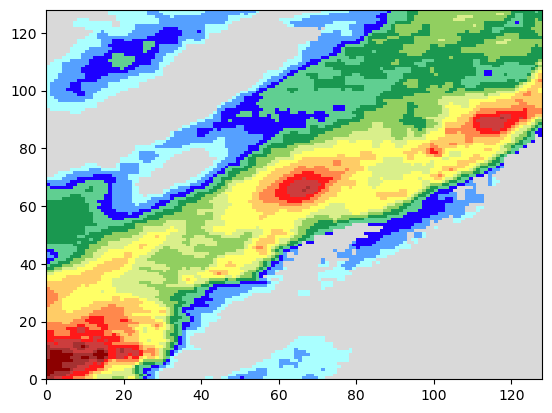

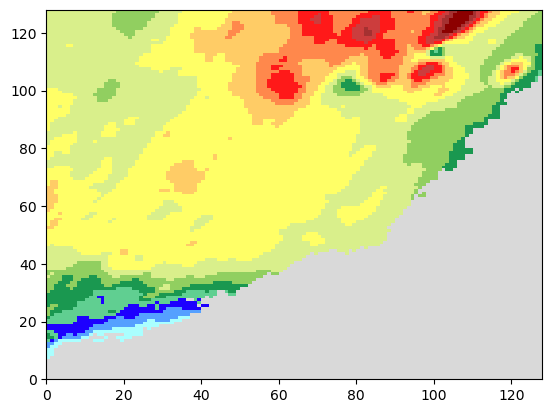

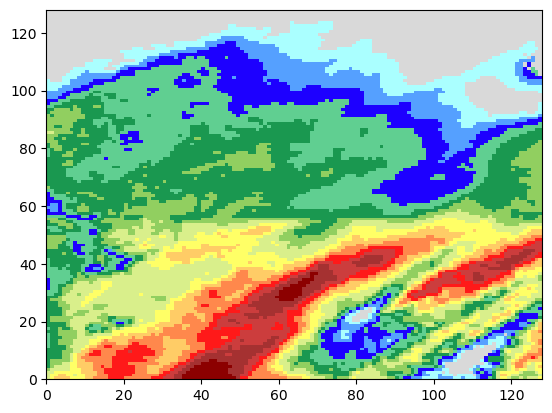

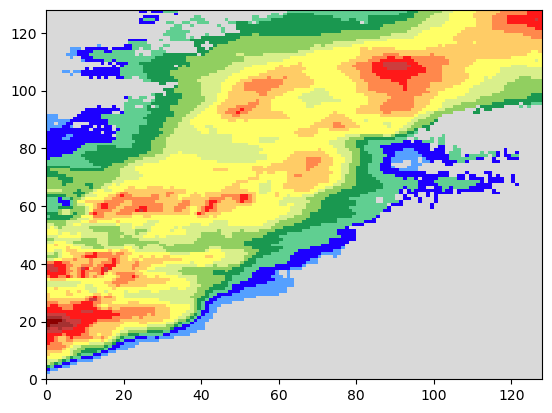

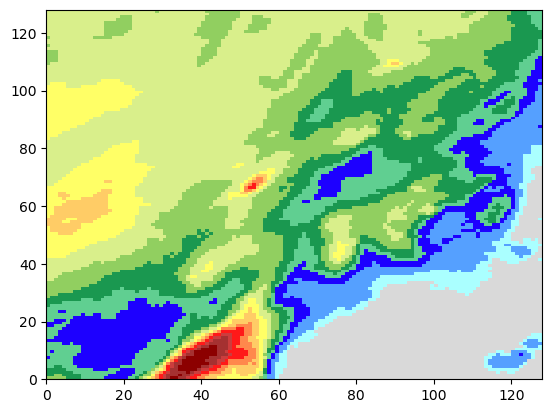

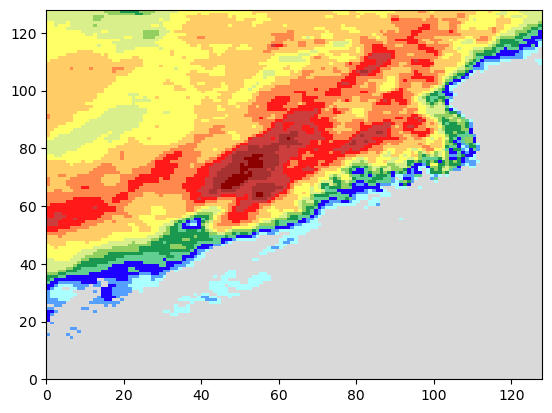

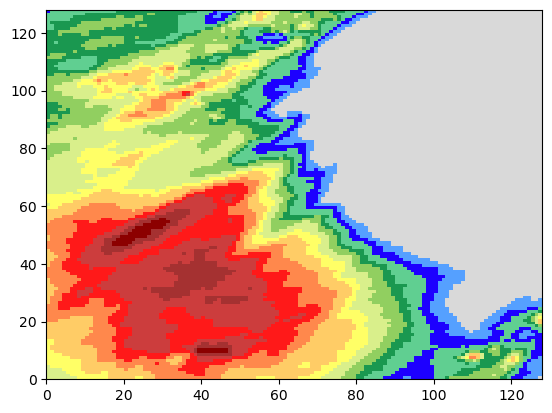

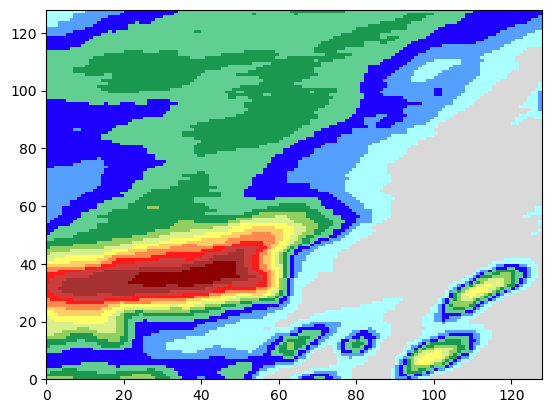

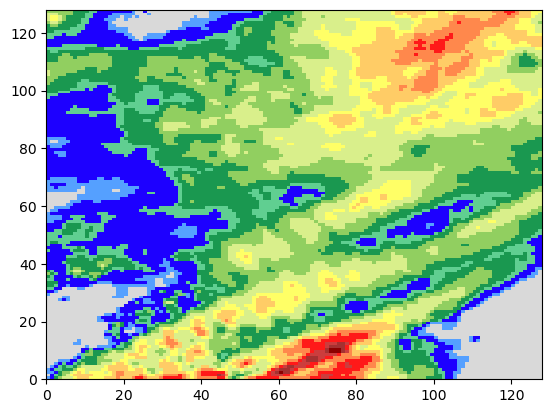

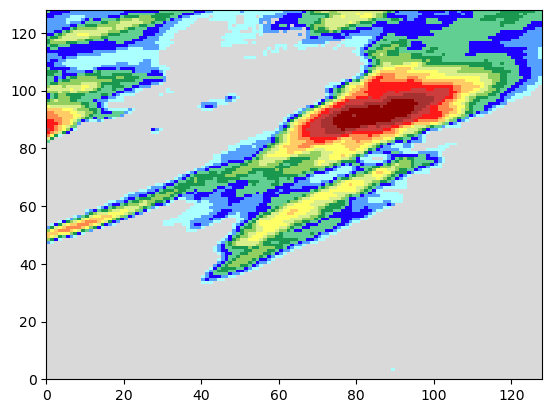

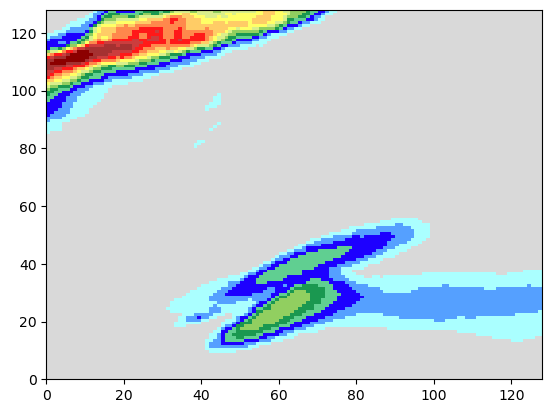

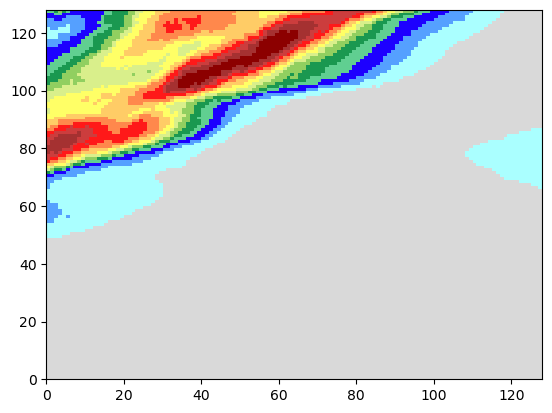

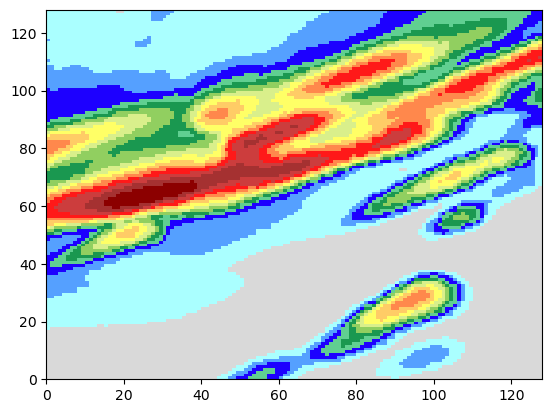

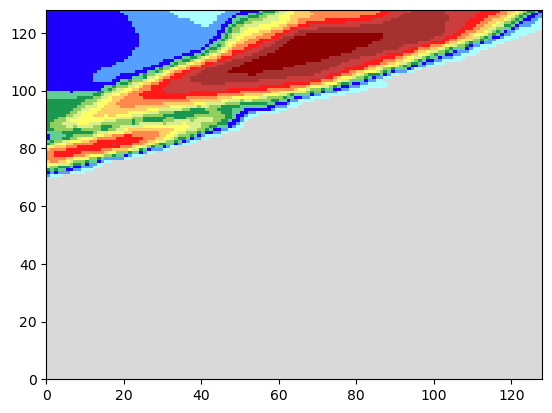

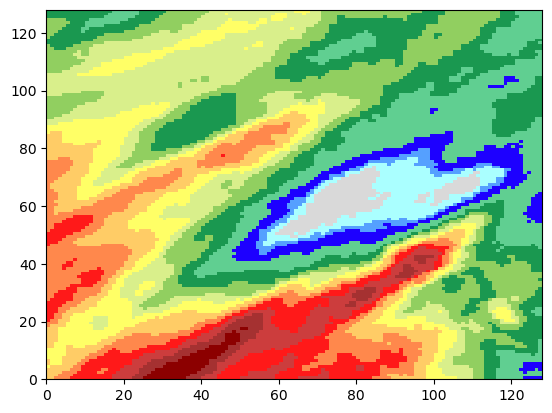

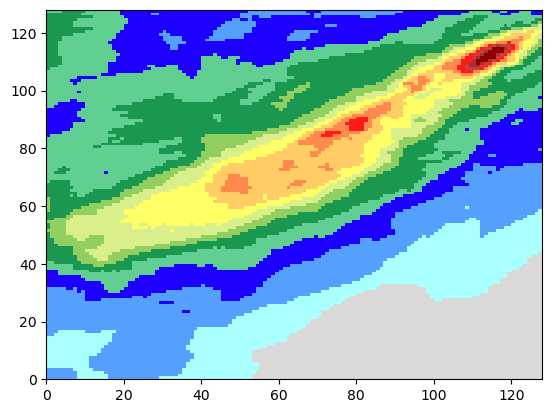

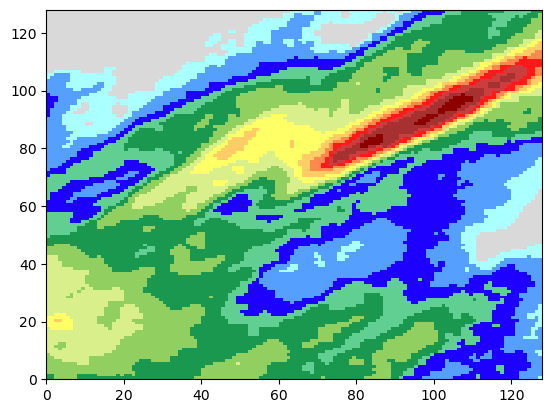

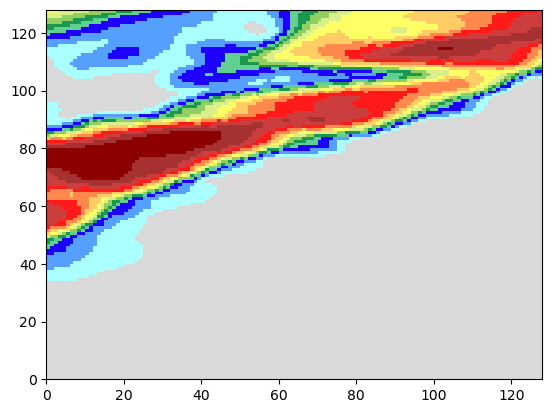

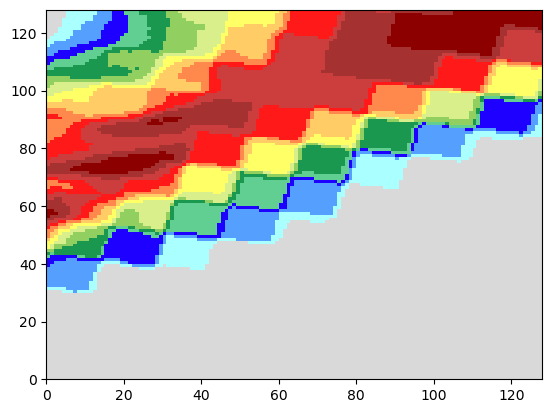

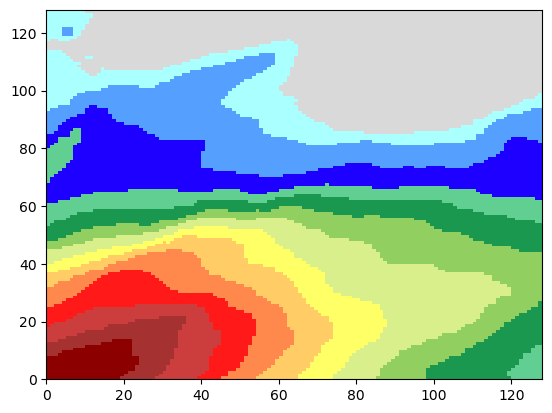

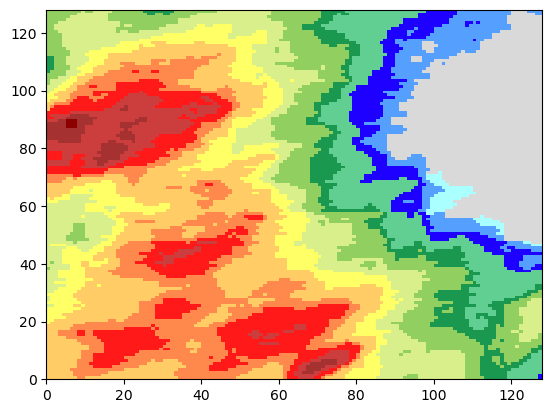

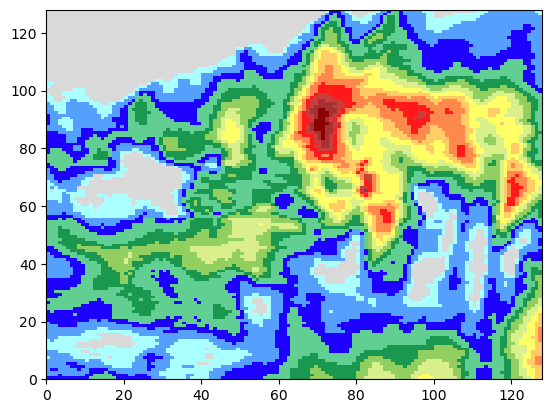

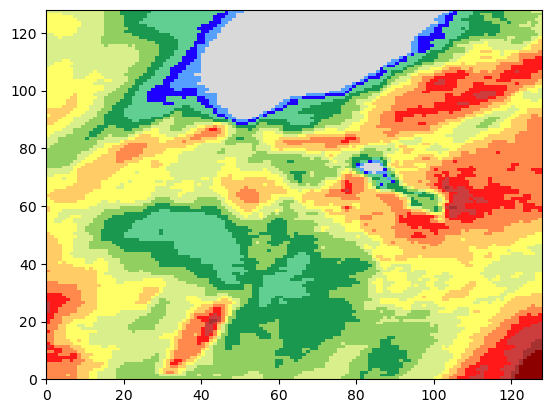

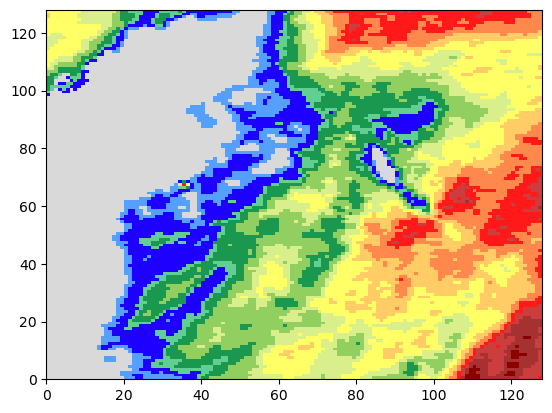

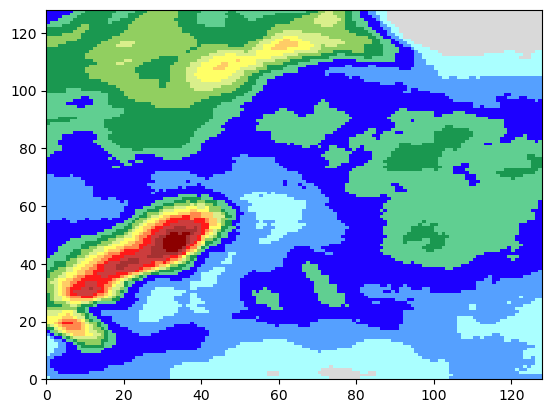

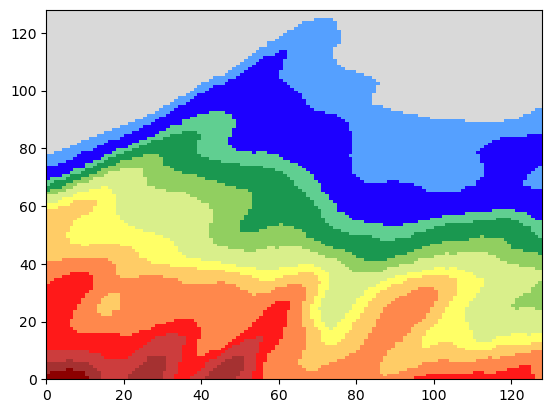

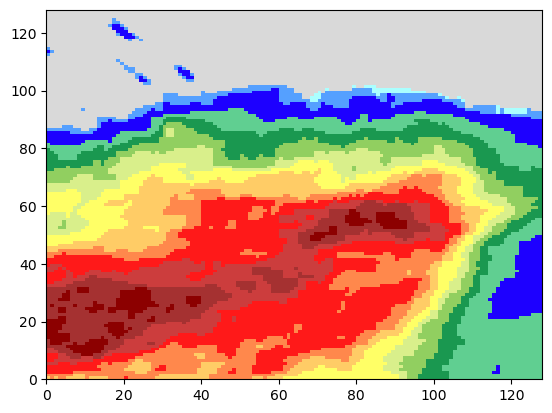

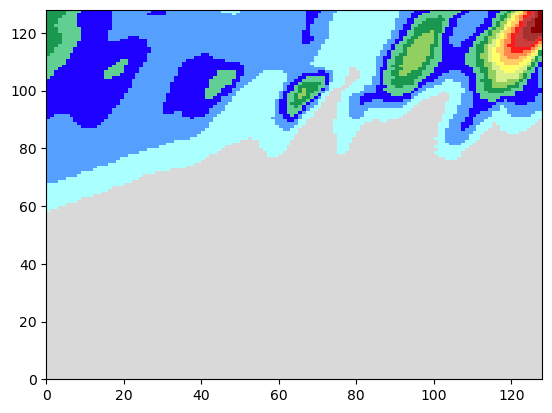

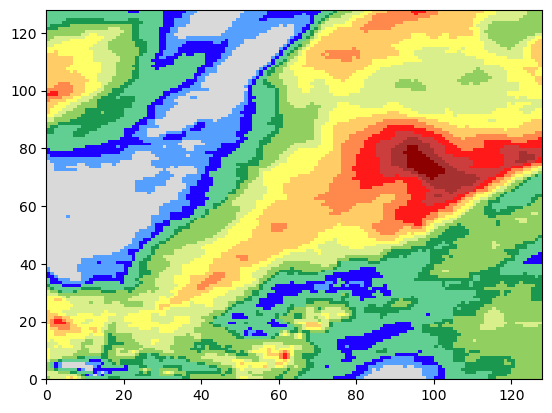

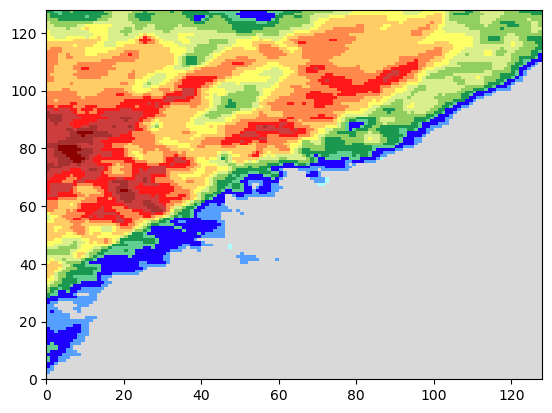

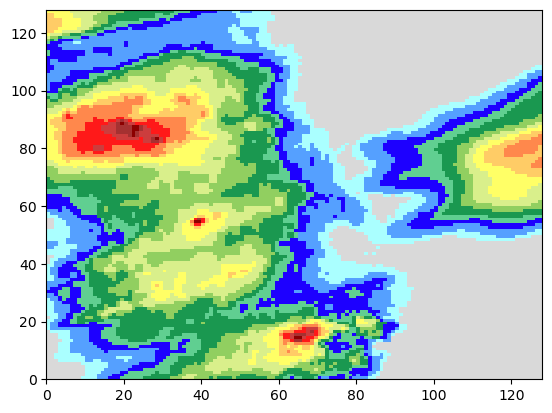

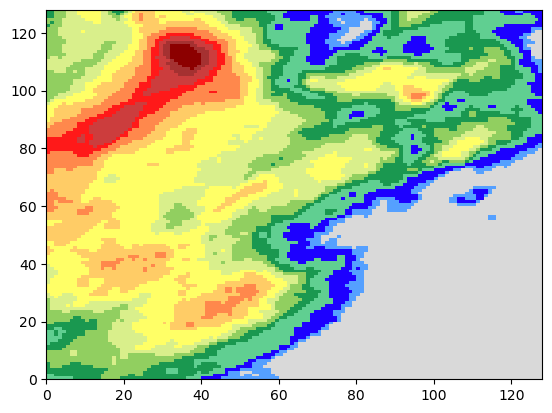

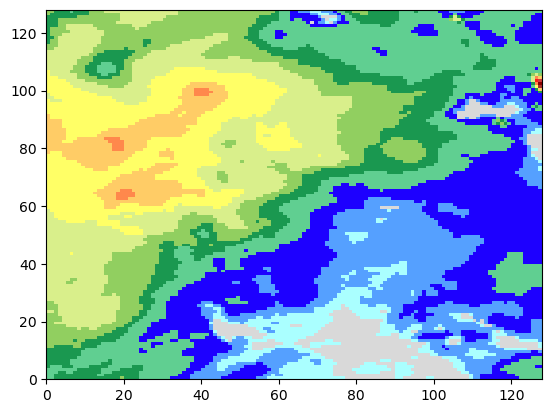

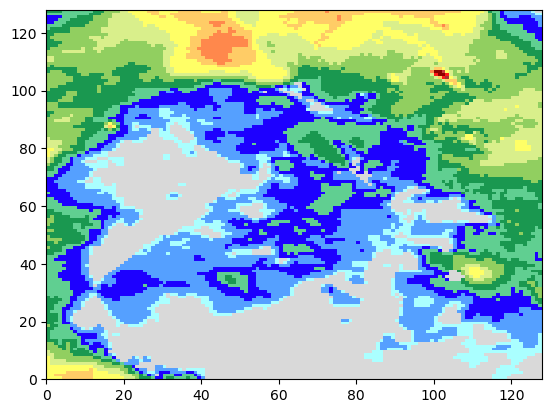

In [229]:
for i in range(100):
    name = filename_valid[i]
    temp_data = np.load(name)
    plt.figure()
    plt.pcolormesh(temp_data[0, ..., 0], cmap=cmap_pct)